<div class="alert alert-block alert-info">
# fifa analysis: skill prediction
---

## summary
* My goal is to predict the overall skill of players.
* I build a linear model that uses the highest correlated attributes.

## context
This is an exercise I have created to practice analytics. I am using a dataset from kaggle.com that represents individual fifa players. My goal is to provide insights for a team manager from the data. I assume that the team manager wants to optimize for the most skilled team that brings the most money. In this analysis, I assume that the manager wants to collect his own data by sending scouts to measure specific attributes of potential players. The goal is to first specify the fewest number of attributes that the manager needs to measure. Based on this, the goal is to provide a predictive model that uses these attributes as inputs, and outputs an overall rating.
   
## data
* Player personal attributes (Nationality, Club, Photo, Age, Value etc.)
* Player performance attributes (Overall, Potential, Aggression, Agility etc.)
* Player preferred position and ratings at all positions.

## key features
* Overall: overall rating of a player, on a scale from 1 to 100.
* Potential: the highest overall rating a player could progress to.
* Value: current market value of a player, annually
* Wage: the weekly wage of a player
---


---
# EDA: correlations

## problem
Which attributes are most highly correlated with overall skill? Secondarily, are these the same skills that are correlated with age?

## hypothesis
The attributes most highly correlated with overall skill are global attributes such as speed. Secondarily, these attributes are also correlated with age.

## assumptions
* Correlations are done irrespective of position. 
* It is possible to calculate the overall skill of a player by looking at his individual attributes, rather than simply using the overall value offered by the dataset.
* Understanding the connection between age and attributes allows us to predict performance by anticipating whether a player will improve as he grows older.

## procedure
* imports
* validate that the distributions of the data are normal
* find attributes that are most highly correlated with overall

### imports

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [141]:
players = pd.read_csv('../data/full_filter_age_adjusted.csv',index_col='index')
players.shape

/Users/nico/code/pydata-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(17929, 79)

### validate normal distribution

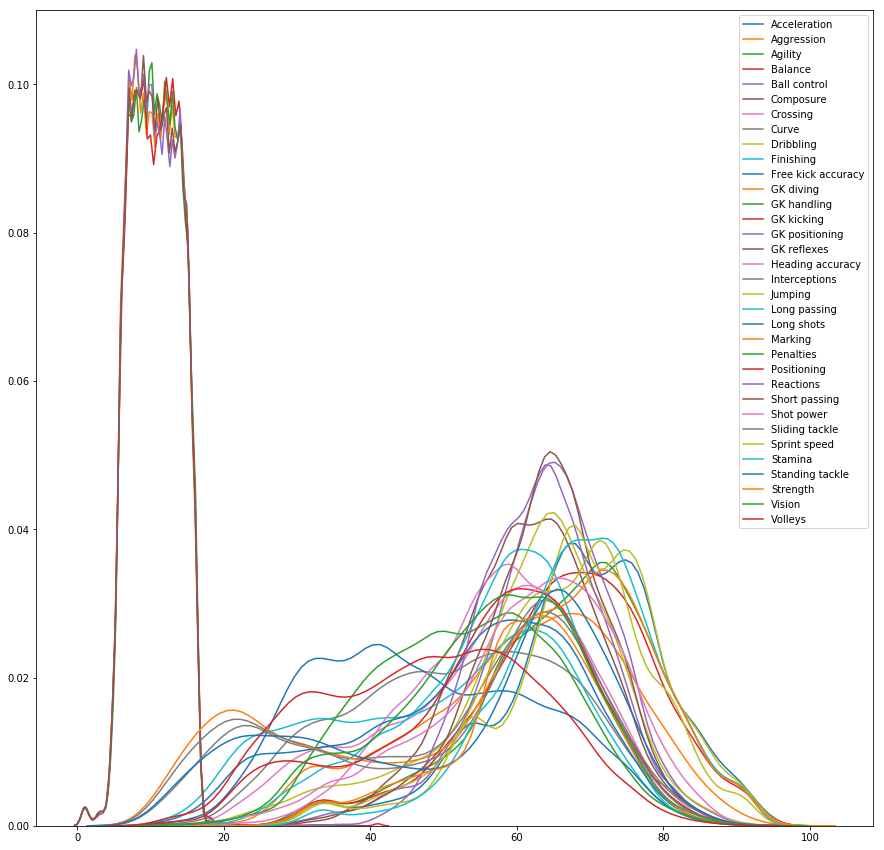

In [142]:


#remove the pluses and minuses from these numbers
import re

skill_columns = ['Acceleration',
       'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
       'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
       'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
       'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys']

def stripValue(value):
    if isinstance(value, str):
        return int(re.findall('\d+',value)[0])
    else:
        return None
    
# remove missing data
players.dropna(inplace=True)

for column in skill_columns:
    players[column] = players[column].apply(stripValue)
    
# remove missing data
players.dropna(inplace=True)

# create plotting objects
fig, ax = plt.subplots(figsize=(15,15))

for column in skill_columns:
    
    sns.distplot(
        players[column],
        bins=50, 
        axlabel=False,
        hist=False,
        kde_kws={"label": column},
        ax=ax,
    )
    
# these distributions are reasonable.
# most of them are skewed left, centered around 60
# many of them have a cluster of low skill

### heat map

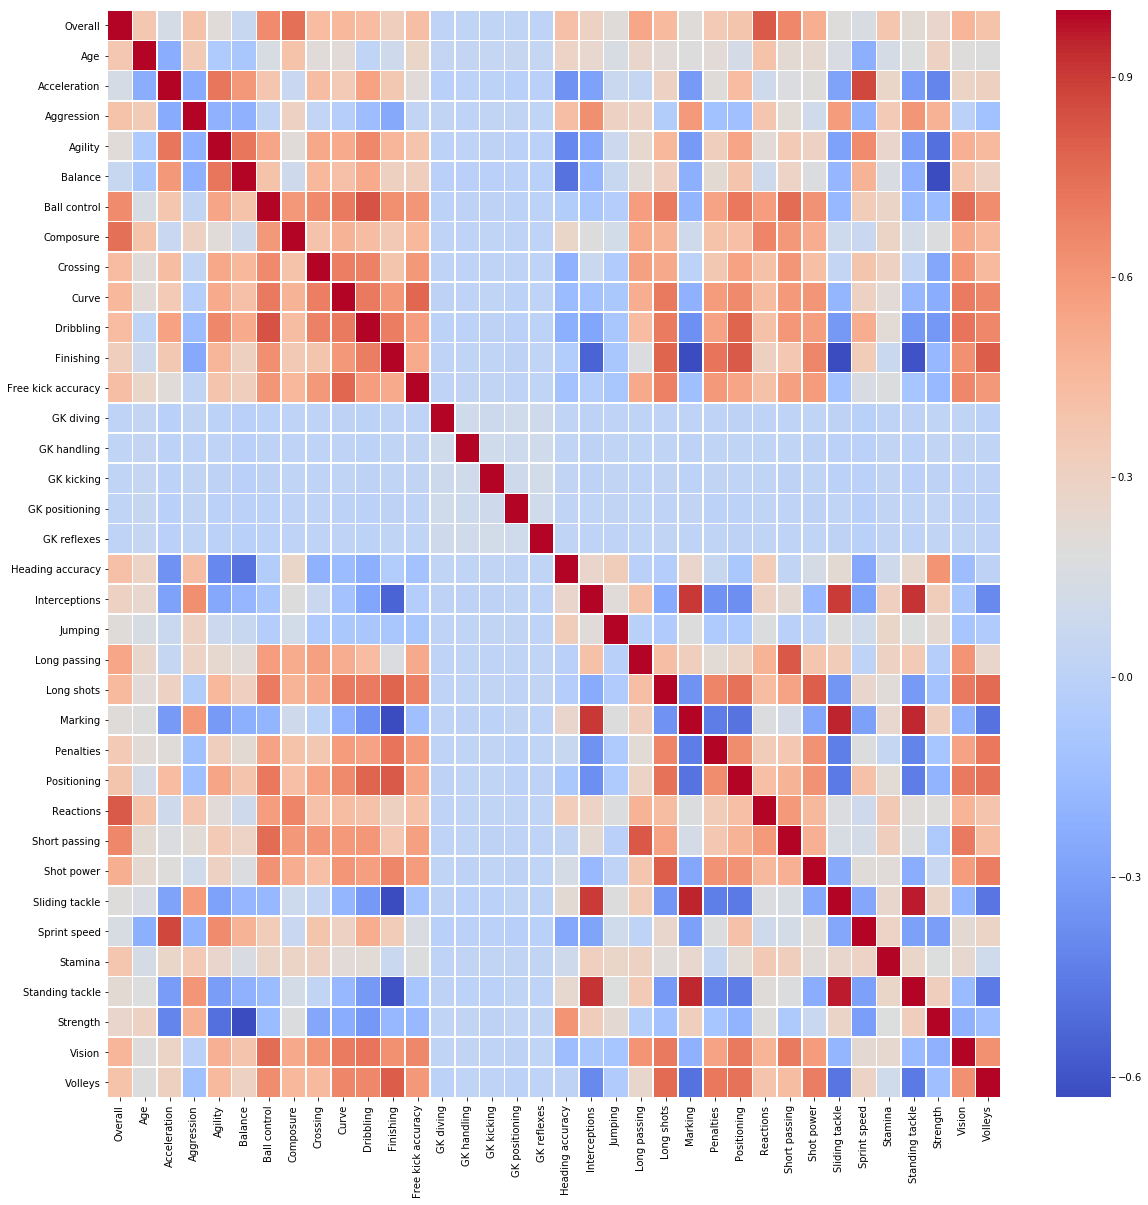

In [143]:
# explore correlations across all skills
correlations = players[['Overall','Age'] + skill_columns].corr()

fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(correlations,annot=False,cmap='coolwarm', linewidths=.5, ax=ax)

### correlation matrix

In [144]:
# explore correlations to overall and age
correlations = correlations.loc[skill_columns,['Overall','Age']]
correlations.sort_values('Overall',ascending=False)



Overall       Age
Reactions           0.812815  0.400907
Composure           0.741791  0.399905
Short passing       0.660311  0.225363
Ball control        0.645842  0.152467
Long passing        0.537197  0.255433
Shot power          0.502117  0.239033
Vision              0.466864  0.191703
Curve               0.456252  0.211423
Long shots          0.443460  0.210411
Dribbling           0.437398  0.018856
Crossing            0.434388  0.208012
Free kick accuracy  0.420607  0.271981
Heading accuracy    0.408378  0.290075
Volleys             0.399616  0.189366
Aggression          0.397973  0.345808
Positioning         0.387686  0.132936
Stamina             0.381907  0.137595
Penalties           0.354856  0.213786
Finishing           0.322000  0.096765
Interceptions       0.297825  0.249488
Strength            0.265932  0.296272
Standing tackle     0.228095  0.179750
Agility             0.204784 -0.058340
Jumping             0.203044  0.149228
Marking             0.202683  0.187960
Sliding tackle      0.195362  0.155629
Sprint speed        0.152429 -0.224433
Acceleration        0.133576 -0.235443
Balance             0.061395 -0.092263
GK kicking          0.021483  0.046782
GK positioning      0.020637  0.052476
GK handling         0.019457  0.040804
GK reflexes         0.017701  0.048943
GK diving           0.016454  0.040324

## conclusion
The top 2 attributes most highly correlated with overall skill are Reactions and Composure. My hypothesis was not supported by these results. I cannot explain why these attributes are the most highly correlated.

---
# linear model comparisons

## problem
Using linear models, what number of predictors is the most cost-effective?

## hypothesis
The single predictor model will be the most cost-effective, because the correlation between reactions and overall is so high.

## assumptions
* the client wants to be able to measure individual attributes of players to predict what their overall skill is
* using an additional attribute costs 2 500 000 euro
* 0.1 reduction in RMSE is worth 1 000 000 euro

## procedure
* for each model
    * train model
    * compare predicted to actual values
    * evaluate model error
    * check distribution of residuals


### 1 predictor linear model

In [145]:
# 1 predictor linear model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = players['Overall'].values.reshape(-1,1)
X = players['Reactions'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


lm = LinearRegression()
lm.fit(X_train,y_train)

coefficients = pd.DataFrame(lm.coef_,['Reactions'])
coefficients.columns = ['Coefficient']
display(coefficients)

Coefficient
Reactions     0.583484

Text(0,0.5,'Predicted Y')

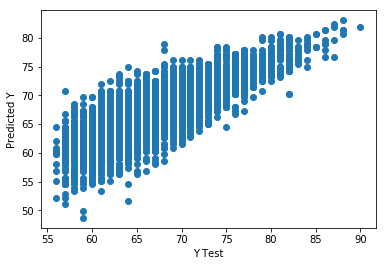

In [146]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [147]:
# evaluate  model performance by calculating the residual sum of squares 
# and the explained variance score (R^2).
from sklearn import metrics

eval_1 = {
    'MAE': metrics.mean_absolute_error(y_test, predictions),
    'MSE': metrics.mean_squared_error(y_test, predictions),
    'RMSE': np.sqrt(metrics.mean_squared_error(y_test, predictions))
}
eval_1

{'MAE': 2.7466787413552751,
 'MSE': 11.866398246535461,
 'RMSE': 3.4447638883580192}

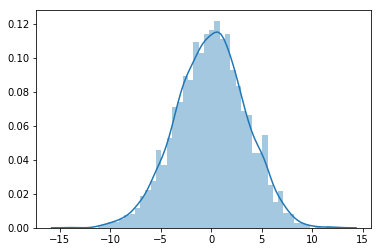

In [148]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

### 2 predictor linear model

In [149]:
y = players['Overall']#.values.reshape(-1,1)
X = players[['Reactions','Composure']]#.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


lm = LinearRegression()
lm.fit(X_train,y_train)

coefficients = pd.DataFrame(lm.coef_,X.columns)
coefficients.columns = ['Coefficient']
display(coefficients)

Coefficient
Reactions     0.413831
Composure     0.220518

Text(0,0.5,'Predicted Y')

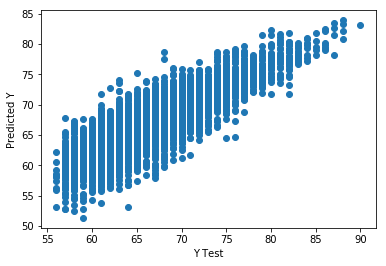

In [150]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [151]:
eval_2 = {
    'MAE': metrics.mean_absolute_error(y_test, predictions),
    'MSE': metrics.mean_squared_error(y_test, predictions),
    'RMSE': np.sqrt(metrics.mean_squared_error(y_test, predictions))
}
eval_2

{'MAE': 2.4384903535432696,
 'MSE': 9.3825332985961651,
 'RMSE': 3.0630921139587306}

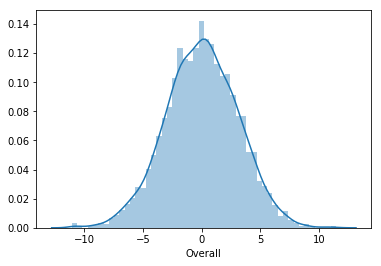

In [152]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

### 3 predictor linear model

In [153]:
y = players['Overall']#.values.reshape(-1,1)
X = players[['Reactions','Composure','Short passing']]#.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


lm = LinearRegression()
lm.fit(X_train,y_train)

coefficients = pd.DataFrame(lm.coef_,X.columns)
coefficients.columns = ['Coefficient']
display(coefficients)

Coefficient
Reactions         0.367217
Composure         0.176515
Short passing     0.122781

Text(0,0.5,'Predicted Y')

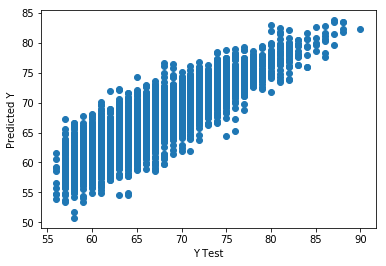

In [154]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [155]:
eval_3= {
    'MAE': metrics.mean_absolute_error(y_test, predictions),
    'MSE': metrics.mean_squared_error(y_test, predictions),
    'RMSE': np.sqrt(metrics.mean_squared_error(y_test, predictions))
}
eval_3

{'MAE': 2.3429345762738314,
 'MSE': 8.7129237458405466,
 'RMSE': 2.9517662078559925}

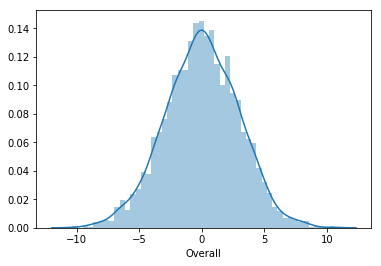

In [156]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

### all predictor linear model

In [157]:
y = players['Overall']
X = players[skill_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient',ascending=False)

Coefficient
Reactions              0.266844
Ball control           0.152384
Composure              0.130087
Short passing          0.107732
Heading accuracy       0.087909
Sprint speed           0.039423
Acceleration           0.034933
Strength               0.032789
Finishing              0.023561
Standing tackle        0.022600
Shot power             0.015560
Free kick accuracy     0.011891
Crossing               0.010494
Curve                  0.006769
Interceptions          0.006438
Jumping                0.005804
Penalties              0.005355
Aggression             0.005323
Marking                0.005219
GK kicking             0.005131
Stamina                0.003086
GK diving              0.000574
GK positioning        -0.001600
Volleys               -0.004444
Dribbling             -0.005511
GK reflexes           -0.006010
GK handling           -0.006473
Long passing          -0.008160
Agility               -0.008338
Sliding tackle        -0.010120
Balance               -0.013053
Long shots            -0.017300
Vision                -0.030436
Positioning           -0.043416

Text(0,0.5,'Predicted Y')

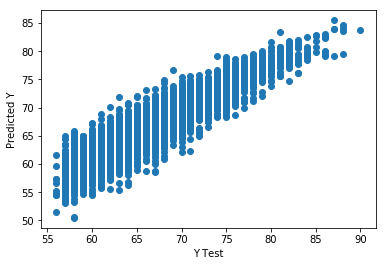

In [158]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [159]:
eval_all = {
    'MAE': metrics.mean_absolute_error(y_test, predictions),
    'MSE': metrics.mean_squared_error(y_test, predictions),
    'RMSE': np.sqrt(metrics.mean_squared_error(y_test, predictions))
}
eval_all

{'MAE': 1.9572466242161661,
 'MSE': 6.1335384613008452,
 'RMSE': 2.4765981630657898}

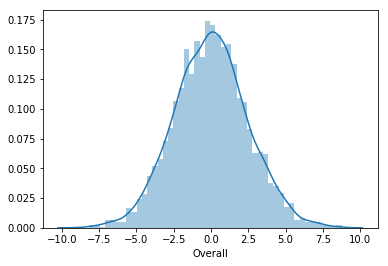

In [160]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

## conclusion



In [161]:
print('eval_1',eval_1)
print('eval_2',eval_2)
print('eval_3',eval_3)
print('eval_all',eval_all)

eval_1 {'MAE': 2.7466787413552751, 'MSE': 11.866398246535461, 'RMSE': 3.4447638883580192}
eval_2 {'MAE': 2.4384903535432696, 'MSE': 9.3825332985961651, 'RMSE': 3.0630921139587306}
eval_3 {'MAE': 2.3429345762738314, 'MSE': 8.7129237458405466, 'RMSE': 2.9517662078559925}
eval_all {'MAE': 1.9572466242161661, 'MSE': 6.1335384613008452, 'RMSE': 2.4765981630657898}


The purpose of this analysis was to come up with a model that predicts overall skill by only looking at specific attributes. The goal was to build a model using as few predictors as possible. it is assumed that because the client significantly more time to measure each additional attribute. Therefore, while it is generally true that adding more attributes improves model accuracy, we must compare the marginal cost to the marginal benefit.

We assume that measuring an additional attribute costs 2 500 000 euro, and that a 0.1 reduction in RMSE is worth 1 000 000 euro.


In [162]:
# We see that adding the second predictor nets positive.
diff = eval_1['RMSE'] - eval_2['RMSE']
value = diff/0.1 * 1000000
print(value)
value > 2500000

3816717.74399


True

In [163]:
# adding a third predictor nets negative
diff = eval_2['RMSE'] - eval_3['RMSE']
value = diff/0.1 * 1000000
print(value)
value > 2500000

1113259.06103


False

Therefore, given our constraints, the 2 predictor model is the most cost-effective. This does not support my hypothesis, however the intuition that highly correlated predictors will provide good accuracy is supported.